# Classification Pipeline

In [1]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC
from src.sugnet.pipeline import FeatureExtractor


In [2]:
CV = GroupShuffleSplit(n_splits=50, test_size=0.2)
CHANCE_CV = GroupShuffleSplit(n_splits=50, test_size=0.2)
n_permutations = 100
output_path = Path('data/classification_output')

In [3]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')

# DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [4]:
# 2. PIPELINE
pipe = Pipeline([
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('select', SelectFromModel(SVC(kernel="linear", max_iter=100000))),
    ('clf', SVC(kernel="linear", probability=True)),
])
# DEBUG: pipe.fit(X, y).score(X, y)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, groups=groups, cv=CV, scoring='accuracy')
scores.mean(), scores.std(), st.bootstrap(scores.reshape(1, -1), np.mean)


(0.4725974025974026,
 0.10262900676765624,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.44502164502164504, high=0.5014718614718614), standard_error=0.014455677651197787))

In [ ]:
grid_params = [{
    'extract__kind': ['correlation source', 'power source', 'power sensor', 'plv source', 'correlation sensor'],
    'extract__frequency_band': ['theta', 'alpha', 'beta', 'gamma', 'all'],
    'pca__n_components': [None, 5, 10],
}]

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X, y, groups=groups)

In [17]:
# prepare grid results to plot
grid_results = pd.DataFrame(grid.cv_results_)
# grid_results['label'] = grid_results['params'].apply(lambda p: ' '.join(list(p.values())))

grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]


split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')


def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CHANCE_CV, scoring='accuracy')
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[f'{model_name}'] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

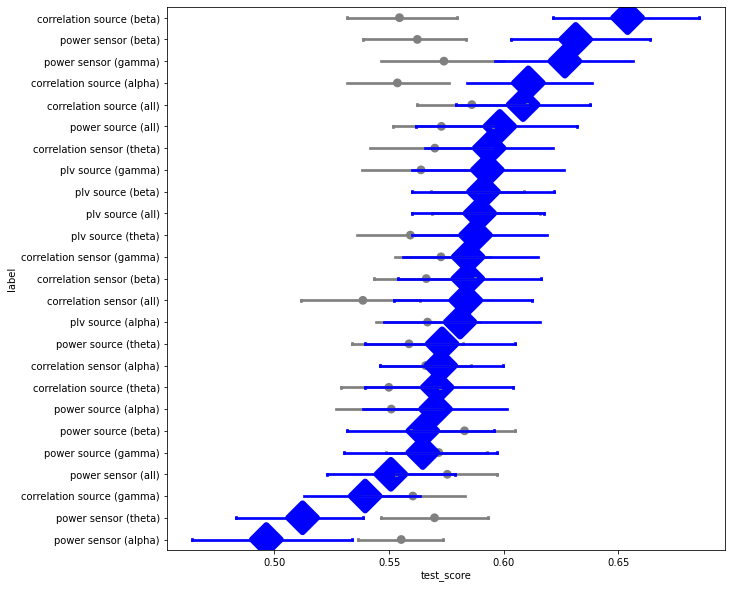

In [18]:
# plot model performance against chance level
_, ax = plt.subplots(1, 1, figsize=(10, 10))
order = grid_results.groupby('label')['test_score'].mean().sort_values(ascending=False).index.values

# plot chance
sns.pointplot(data=chance_scores, ax=ax,
              x='test_score', y='label',
              order=order,
              color='gray',
              capsize=0.03,
              join=False,
              orient='h', label='chance')

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label',
              orient='h',
              order=order,
              ax=ax,
              scale=3,
              cmap='viridis',
              capsize=0.03,
              join=False,
              color='blue',
              markers='D')

# sns.stripplot(data=grid_results, x='test_score', y='label',
#               orient='h',
#               order=order,
#               ax=ax,
#               cmap='viridis',
#               color='blue',
#               marker='D')

plt.show()

## Model Diagnosis

In [8]:
from sklearn.inspection import permutation_importance
from collections import defaultdict
import shap
from tqdm.auto import tqdm


model_names = grid_results.groupby('label')['mean_test_score'].mean().sort_values(ascending=False).index.values
importances = {}
shap_values = {}
y_tests = {}
y_preds = {}


for model_name in model_names[:3]:
    params = grid_results.query('label == @model_name')['params'].iloc[0]
    pipe.set_params(**params)

    X_t = pipe[:-2].fit_transform(X, y)
    feature_names = pipe[:-2].get_feature_names_out()
    model_importances = []
    model_shapes = []
    test_indices = []
    y_test_cv = []
    y_pred_cv = []

    for train, test in tqdm(CV.split(X, y, groups=groups), desc=model_name, total=CV.get_n_splits()):

        model = pipe[-2:].fit(X_t[train], y[train])
        y_pred = model.predict(X_t[test])
        
        test_indices.extend(test)
        y_test_cv.append(y[test])
        y_pred_cv.append(y_pred)
        
        explainer = shap.Explainer(model.predict, X_t[train], feature_names=feature_names)
        cv_shap_values = explainer(X_t[test], max_evals=len(feature_names)*2+1)
        model_shapes.append(cv_shap_values)

        perm_scores = permutation_importance(model, X_t[test], y[test], n_repeats=10)
        cv_importances = pd.DataFrame(perm_scores['importances'].T, columns=feature_names)
        model_importances.append(cv_importances)
    
    importances[model_name] = pd.concat(model_importances)
    
    y_tests[model_name] = np.hstack(y_test_cv)
    y_preds[model_name] = np.hstack(y_pred_cv)
    
    shap_values[model_name] = shap.Explanation(
        values=np.vstack([sh.values for sh in model_shapes]),
        base_values=np.hstack([sh.base_values for sh in model_shapes]),
        data=np.vstack([sh.data for sh in model_shapes]),
        feature_names=feature_names,
        output_indexes=y_pred,
        output_names=['low', 'high']
    )
    


AttributeError: Estimator pca does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

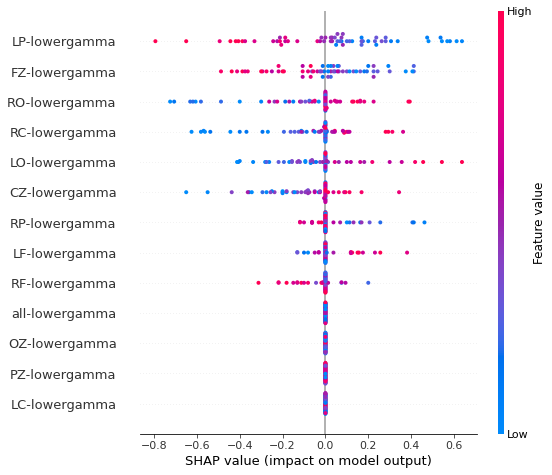

In [242]:
shap.summary_plot(shap_values['gamma power sensor'])

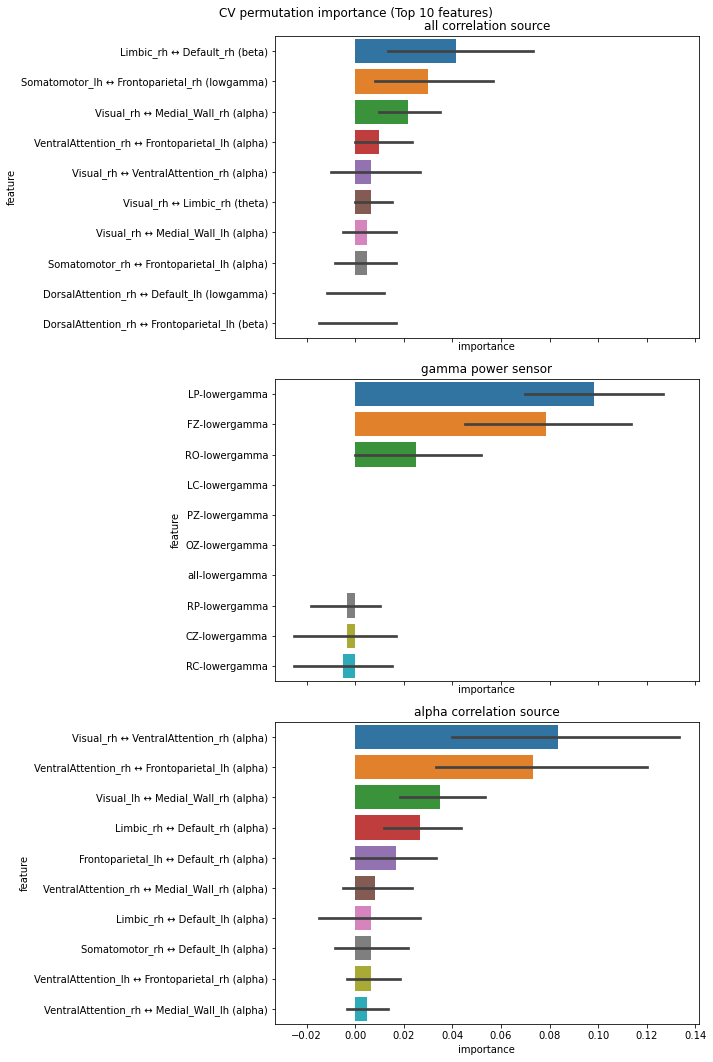

In [247]:
# plot top 10 features

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

for i, (model_name, model_importances) in enumerate(importances.items()):
    
    order = model_importances.mean(axis=0).sort_values(ascending=False).index
    importances_long = model_importances.melt(var_name='feature', value_name='importance')
    
    sns.barplot(data=importances_long, x='importance', y='feature', order=order[:10], ax=axes[i])
    
    axes[i].set_title(model_name)
plt.suptitle('CV permutation importance (Top 10 features)')
plt.tight_layout()
plt.show()


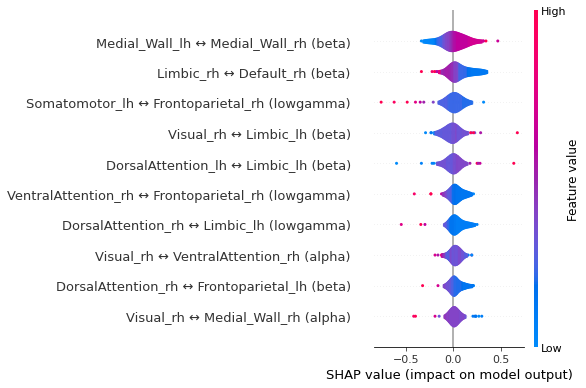

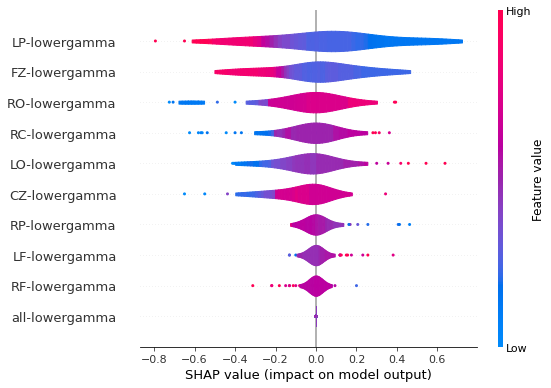

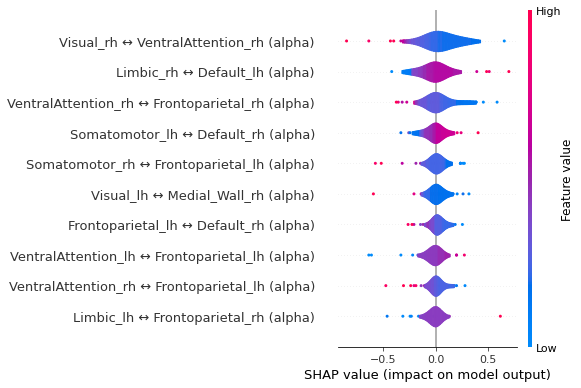

In [250]:
for model_name in shap_values.keys():
    
    shap.summary_plot(shap_values[model_name], max_display=10, plot_type='violin')

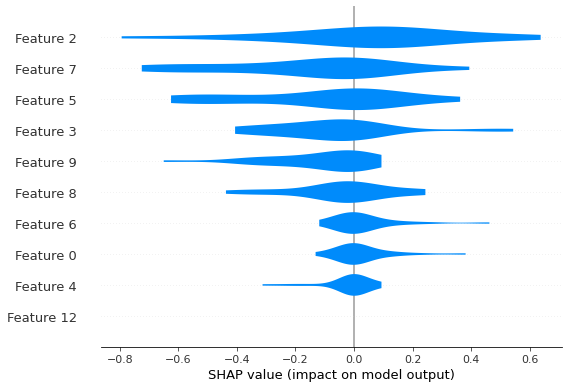

In [252]:
model_name = 'gamma power sensor'

misclassified_mask = np.where(y_preds[model_name] != y_tests[model_name])[0]
misclassified_mask_shap = shap_values[model_name].values[misclassified_mask]
shap.summary_plot(misclassified_mask_shap, max_display=10, plot_type='violin')